# Bellman Equation Collocation Method

In [1]:
using BasisMatrices
using QuantEcon
using Optim
using Plots

For discrete time dynamic programs
with 1-dimenstional continuous states and actions:

In [2]:
struct DPModel{N}
    f::Function
    g::Function
    discount::Float64
    shocks::Vector{Float64}
    weights::Vector{Float64}
    n::Int  # Size of state grid
    basis::Basis{N}
    S::Vector{Float64}
    Phi_lu::LinAlg.LU{Float64,Matrix{Float64}}
    lb::Function
    ub::Function
end

In [3]:
function DPModel{N}(f::Function, g::Function, discount::Float64, 
                    shocks::Vector{Float64}, weights::Vector{Float64},
                    basis::Basis{N},
                    lb::Function, ub::Function)
    S, _ = nodes(basis)
    n = length(basis)
    Phi = BasisMatrix(basis, Expanded(), S).vals[1]
    Phi_lu = lufact(Phi)
    dp = DPModel{N}(f, g, discount, shocks, weights, n, basis, S, Phi_lu, lb, ub)
    return dp
end

DPModel

In [4]:
function vmax(dp::DPModel, s::Float64, C::Vector{Float64})
    objective(x) = -dp.f(s, x) -
        dp.discount * (dp.weights' * funeval(C, dp.basis, dp.g.(s, x, dp.shocks)))
    res = optimize(objective, lb(s), ub(s))
    v = -res.minimum::Float64
    x = res.minimizer::Float64
    return v, x
end

vmax (generic function with 1 method)

In [5]:
function vmax!(dp::DPModel, ss::AbstractVector{Float64}, C::Vector{Float64},
               Tv::Vector{Float64})
    for (i, s) in enumerate(ss)
        Tv[i], _ = vmax(dp, s, C)
    end
    return Tv
end

function vmax!(dp::DPModel, ss::AbstractVector{Float64}, C::Vector{Float64},
               Tv::Vector{Float64}, X::Vector{Float64})
    for (i, s) in enumerate(ss)
        Tv[i], X[i] = vmax(dp, s, C)
    end
    return Tv, X
end

function vmax(dp::DPModel, ss::AbstractVector{Float64}, C::Vector{Float64})
    Tv, X = similar(ss),similar(ss)
    vmax!(dp, ss, C, Tv, X)
end

vmax (generic function with 2 methods)

In [6]:
function bellman_operator!(dp::DPModel, C::Vector{Float64},
                           Tv::Vector{Float64})
    Tv = vmax!(dp, dp.S, C, Tv)
    A_ldiv_B!(C, dp.Phi_lu, Tv)
    return C
end

bellman_operator! (generic function with 1 method)

In [7]:
function operator_iteration!{TC}(T::Function, C::TC;
                                 tol::Float64=1e-4, max_iter::Int=100,
                                 verbose::Int=2, print_skip::Int=50)
    i = 0
    err = tol + 1
    C_old = similar(C)
    while i < max_iter && err > tol
        copy!(C_old, C)
        C = T(C)::TC
        err = maximum(abs, C - C_old)
        i += 1
        
        (i >= max_iter || err <= tol) && break
        
        if (verbose == 2) && (i % print_skip == 0)
            println("Compute iterate $i with error $err")
        end
    end
    
    if verbose == 2
        println("Compute iterate $i with error $err")
    end
    
    if verbose >= 1
        if err > tol
            warn("max_iter attained")
        elseif verbose == 2
            println("Converged in $i steps")
        end
    end
    
    return C
end

operator_iteration! (generic function with 1 method)

## Optimal Economic Growth

In [8]:
n = 10
s_min, s_max = 5, 10;

In [9]:
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb


In [10]:
alpha = 0.2
bet = 0.5
gamm = 0.9
sigma = 0.1
discount = 0.9;

In [11]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

In [12]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
g(s, x, e) = gamm * x + e * x^bet;

In [13]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, 0, sigma^2)

([0.840965, 1.0, 1.18911], [0.166667, 0.666667, 0.166667])

In [14]:
lb(s) = 0
ub(s) = s;

In [15]:
dp = DPModel(f, g, discount, shocks, weights, basis, lb, ub)

DPModel{1}(f, g, 0.9, [0.840965, 1.0, 1.18911], [0.166667, 0.666667, 0.166667], 10, 1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb
, [5.03078, 5.27248, 5.73223, 6.36502, 7.10891, 7.89109, 8.63498, 9.26777, 9.72752, 9.96922], Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; 1.0 1.0 … 0.0 0.0; … ; 1.0 0.0489435 … 1.0 0.0; 1.0 0.579192 … -0.45965 1.0]
[1.0 -0.987688 … 0.309017 -0.156434; 0.0 1.97538 … -1.4877e-14 0.312869; … ; 0.0 0.0 … -5.25731 1.64485; 0.0 0.0 … 0.0 5.06233], lb, ub)

In [20]:
tol = 1e-9
max_iter = 250
Tv = Array{Float64}(dp.n)  # Temporary array
bellman_operator!(C) = bellman_operator!(dp, C, Tv)
C = zeros(n)
C = operator_iteration!(bellman_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 50 with error 0.008638196659472186
Compute iterate 100 with error 4.4519323829206314e-5
Compute iterate 150 with error 2.2944259114865417e-7
Compute iterate 200 with error 1.182499431706674e-9
Compute iterate 202 with error 9.578258186593303e-10
Converged in 202 steps


In [21]:
s_min, s_max = 5, 10
grid_size = 100
ss = linspace(s_min, s_max, grid_size)
V, X = vmax(dp, ss, C)
resid = V - funeval(C, dp.basis, ss);


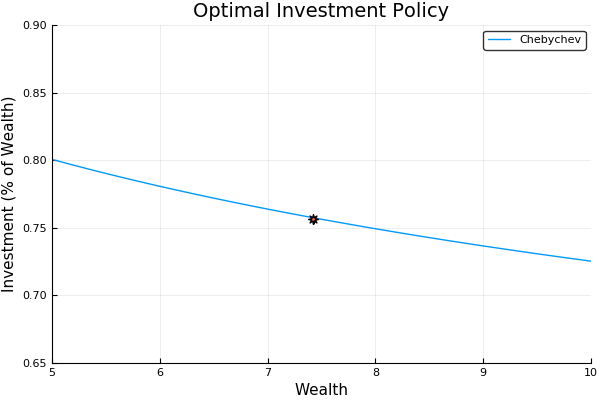

In [22]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


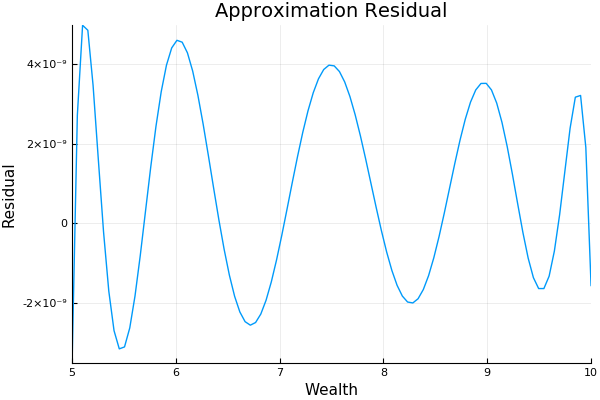

In [23]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")